In [1]:
from mxnet import init
from mxnet import gluon
from mxnet.gluon import nn
from mxnet import nd
from mxnet import image
from mxnet import autograd
import numpy as np
import pickle as p
import mxnet as mx
from time import time
import matplotlib.pyplot as plt
ctx = mx.gpu()

In [2]:
def pic_aug(pic):
    pic = nd.array(pic)
    pic = nd.transpose(pic, (0, 2, 3, 1))
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), resize=36, rand_crop=True, rand_mirror=True)
    a = nd.zeros((len(pic),32,32,3))
    for i in range(len(pic)):
        im = pic[i]
        for aug in auglist:
            im = aug(im)
        a[i] = im
    a  = nd.transpose(a, (0, 3, 1, 2))
    return a

def accuracy(output, label):
    return nd.mean(output.argmax(axis=1)==label).asscalar()

def evaluate_accuracy(data_iterator, net, ctx):
    acc = 0.
    for data, label in data_iterator:
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        acc += accuracy(output, label)
    return acc / len(data_iterator)

class Residual(nn.Block):
    def __init__(self, channels, same_shape=True, **kwargs):
        super(Residual, self).__init__(**kwargs)
        self.same_shape = same_shape
        with self.name_scope():
            strides = 1 if same_shape else 2
            self.conv1 = nn.Conv2D(channels, kernel_size=3, padding=1, strides=strides)
            self.bn1 = nn.BatchNorm()
            self.conv2 = nn.Conv2D(channels, kernel_size=3, padding=1)
            self.bn2 = nn.BatchNorm()
            if not same_shape:
                self.conv3 = nn.Conv2D(channels, kernel_size=1, strides=strides)
    def forward(self, x):
        out = nd.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if not self.same_shape:
            x = self.conv3(x)
        return nd.relu(out + x)

class ResNet(nn.Block):
    def __init__(self, num_classes, **kwargs):
        super(ResNet, self).__init__(**kwargs)
        with self.name_scope(): 
            b1 = nn.Conv2D(16, kernel_size=3, strides=1, padding=1)
            b2 = nn.Sequential()
            b2.add(Residual(16),Residual(16))
            b3 = nn.Sequential()
            b3.add(Residual(32, same_shape=False),Residual(32))
            b4 = nn.Sequential()
            b4.add(nn.AvgPool2D(pool_size=3),nn.Dense(num_classes))
            self.net = nn.Sequential()
            self.net.add(b1, b2, b3, b4)
    def forward(self, x):
        out = x
        for i, b in enumerate(self.net):
            out = b(out)
        return out

In [3]:
route = '/home/sinyer/Python/data'
train_num = 50000
test_num = 10000
batch_size = 256
def load_CIFAR_batch(filename):
    with open(filename, 'rb')as f:
        data_dict = p.load(f, encoding='latin1')
        X = data_dict['data']
        Y = data_dict['labels']
        X = X.reshape(10000, 3, 32,32).astype("float")
        Y = np.array(Y)
        return X, Y
def load_CIFAR_Labels(filename):
    with open(filename, 'rb') as f:
        label_names = p.load(f, encoding='latin1')
        names = label_names['label_names']
        return names
label_names = load_CIFAR_Labels(route + "/cifar-10-batches-py/batches.meta")
img_X1, img_Y1 = load_CIFAR_batch(route + "/cifar-10-batches-py/data_batch_1")
img_X2, img_Y2 = load_CIFAR_batch(route + "/cifar-10-batches-py/data_batch_2")
img_X3, img_Y3 = load_CIFAR_batch(route + "/cifar-10-batches-py/data_batch_3")
img_X4, img_Y4 = load_CIFAR_batch(route + "/cifar-10-batches-py/data_batch_4")
img_X5, img_Y5 = load_CIFAR_batch(route + "/cifar-10-batches-py/data_batch_5")
test_pic, test_label = load_CIFAR_batch(route + "/cifar-10-batches-py/test_batch")
train_pic = np.concatenate((img_X1, img_X2, img_X3, img_X4, img_X5))
train_label = np.concatenate((img_Y1, img_Y2, img_Y3, img_Y4, img_Y5))
X = train_pic[:train_num,:].astype('float32')/255
y = train_label[:train_num].astype('float32')
X_ = test_pic[:test_num,:].astype('float32')/255
y_ = test_label[:test_num].astype('float32')
mean=np.array([0.4914, 0.4822, 0.4465])
std=np.array([0.2023, 0.1994, 0.2010])
for i in range(3):
    X[:,:,:,i] = (X[:,:,:,i] - mean[i]) / std[i]
    X_[:,:,:,i] = (X_[:,:,:,i] - mean[i]) / std[i]
X = pic_aug(X)
train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(X, y), batch_size, shuffle=True)
test_data = gluon.data.DataLoader(gluon.data.ArrayDataset(X_, y_), batch_size, shuffle=False)

In [4]:
net = ResNet(10)
net.initialize(init=init.Xavier(), ctx=ctx)
loss = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.05, 'momentum': 0.9, 'wd': 5e-4})

Epoch 0, Loss: 1.766082, Train acc 0.366932, Test acc 0.358105, Time 11.864912
Epoch 10, Loss: 0.637588, Train acc 0.777152, Test acc 0.697656, Time 6.692898
Epoch 20, Loss: 0.486149, Train acc 0.829361, Test acc 0.741895, Time 6.768373
Epoch 30, Loss: 0.412600, Train acc 0.855859, Test acc 0.670508, Time 6.757458
Epoch 40, Loss: 0.361617, Train acc 0.871022, Test acc 0.671191, Time 6.866480
Epoch 50, Loss: 0.346267, Train acc 0.877866, Test acc 0.698730, Time 6.775422
Epoch 60, Loss: 0.258671, Train acc 0.915115, Test acc 0.769531, Time 6.787813
Epoch 70, Loss: 0.085564, Train acc 0.985152, Test acc 0.762012, Time 6.760956


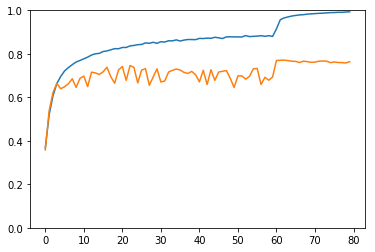

In [5]:
epochs = 80
lr_period = 60
lr_decay = 0.1

a = []
b = []
for epoch in range(epochs):
    if epoch > 0 and epoch % lr_period == 0:
        trainer.set_learning_rate(trainer.learning_rate * lr_decay)
    train_loss = 0.
    train_acc = 0.
    batch = 0
    start = time()
    for data, label in train_data:
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            L = loss(output, label)
        L.backward()
        trainer.step(data.shape[0])
        train_loss += nd.mean(L).asscalar()
        train_acc += accuracy(output, label)
        batch += 1
    a.append(train_acc/batch)
    test_acc = evaluate_accuracy(test_data, net, ctx)
    b.append(test_acc)
    if epoch%10 == 0:
        print("Epoch %d, Loss: %f, Train acc %f, Test acc %f, Time %f" % (epoch, train_loss/batch, train_acc/batch, test_acc, time() - start))
plt.plot(np.arange(0, epochs),a,np.arange(0, epochs),b)
plt.ylim(0, 1)
plt.show()